# Check the distributions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

# log uniform

In [2]:
test_file = './planets/test_uniform_draw/test_uniform_draw.planets.0.0'

# read comma separated text file as pandas df 
# the first row is the header, which is the column names, starting with '#'
# ignore the "# " at the beginning of the header line

df = pd.read_csv(test_file, sep=',', header=0)
df.columns.values[0] = df.columns[0].replace('# ', '')
# Strip whitespace from all column names for easier access
df.columns = df.columns.str.strip()

# print the first 5 rows of the df
print(df.head())


   mass (M_Sun)     a (au)  inc (deg)     p (deg)
0  9.964205e-05   2.359946 -74.195092   20.064217
1  3.644432e-04  11.464742  47.474606  110.713903
2  3.070556e-05   0.393287 -78.813765  167.535386
3  1.294115e-06   1.139527  56.912344  154.208964
4  3.498199e-07   4.404047  63.618584  172.177252


In [3]:
print(df.columns)

Index(['mass (M_Sun)', 'a (au)', 'inc (deg)', 'p (deg)'], dtype='object')


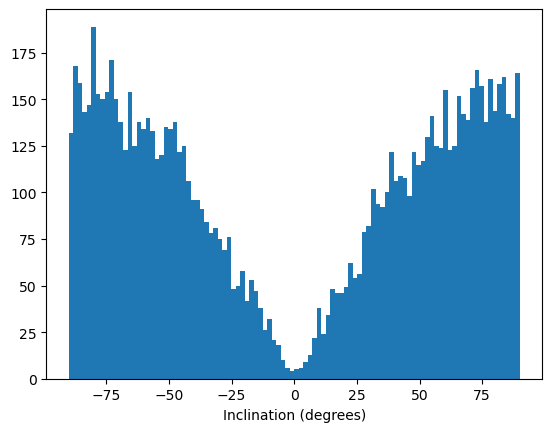

In [4]:
# histogram of the inclination column
import matplotlib.pyplot as plt
plt.hist(df['inc (deg)'], bins=100)
plt.xlabel('Inclination (degrees)')
plt.show()

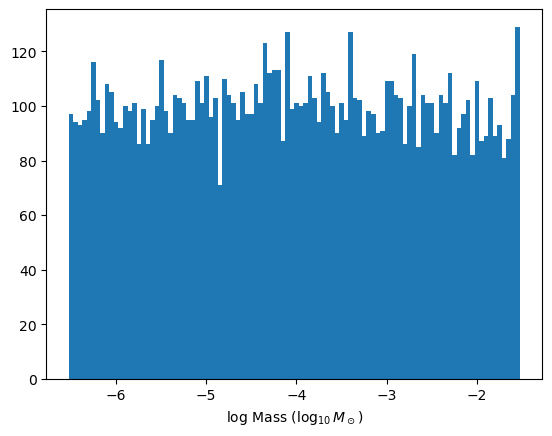

In [13]:
#histogram of the mass column
plt.hist(np.log10(df['mass (M_Sun)']), bins=100)
plt.xlabel(r'log Mass ($\log_{10}M_\odot$)')
plt.show()

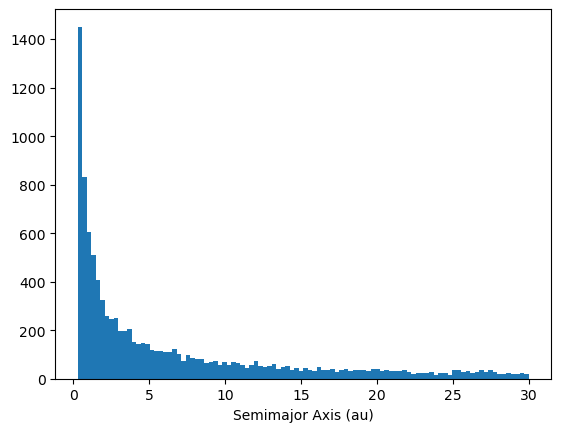

In [6]:
#histogram of the semimajor axis column
plt.hist(df['a (au)'], bins=100)
plt.xlabel(r'Semimajor Axis (au)')
plt.show()

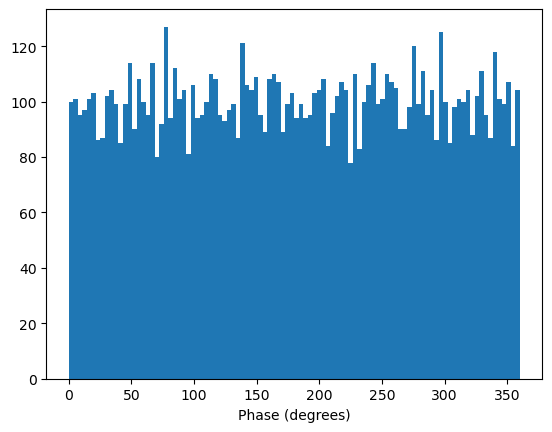

In [7]:
#histogram of the phase column
plt.hist(df['p (deg)'], bins=100)
plt.xlabel(r'Phase (degrees)')
plt.show()

## Sumi et al. 2023

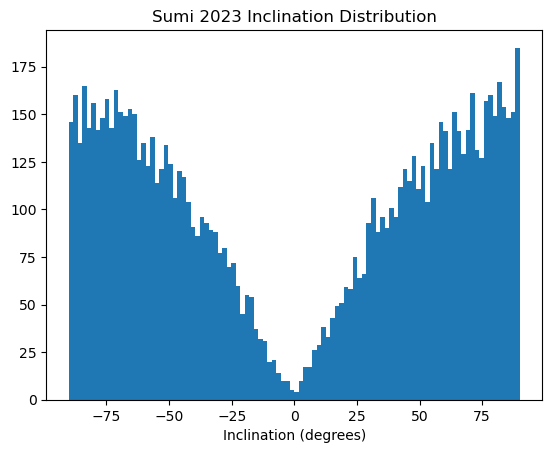

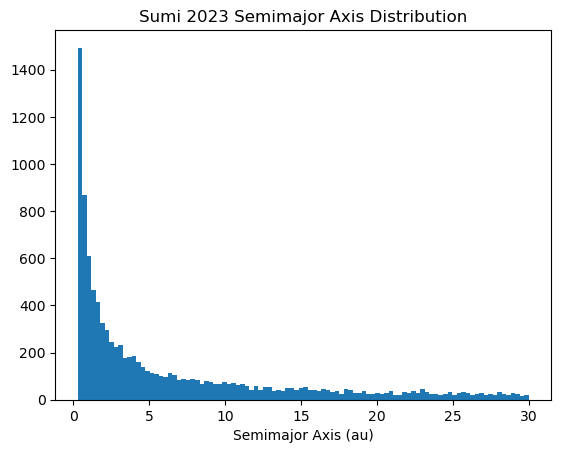

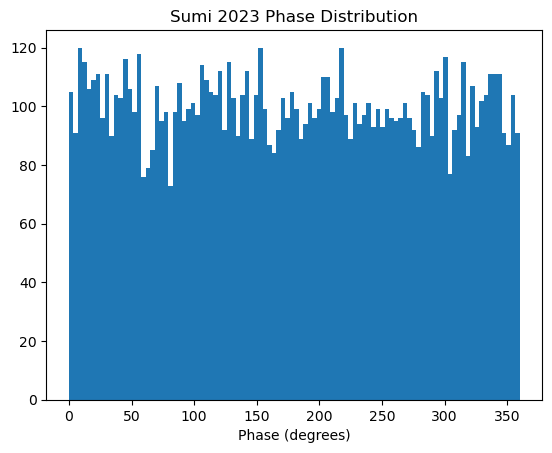

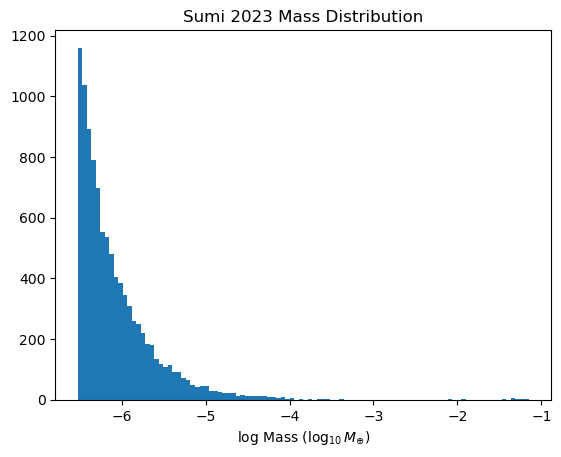

In [8]:
# Inclination distribution for Sumi 2023

# Find a sample file from the Sumi 2023 run
sumi_files = sorted(glob.glob('planets/test_Sumi2023/*.planets.*'))
if sumi_files:
    sumi_df = pd.read_csv(sumi_files[0], sep=',', header=0)
    sumi_df.columns.values[0] = sumi_df.columns[0].replace('# ', '')
    sumi_df.columns = sumi_df.columns.str.strip()
    plt.hist(sumi_df['inc (deg)'], bins=100)
    plt.xlabel('Inclination (degrees)')
    plt.title('Sumi 2023 Inclination Distribution')
    plt.show()
else:
    print('No Sumi 2023 planet files found.')

# Semimajor axis distribution for Sumi 2023
if sumi_files:
    plt.hist(sumi_df['a (au)'], bins=100)
    plt.xlabel('Semimajor Axis (au)')
    plt.title('Sumi 2023 Semimajor Axis Distribution')
    plt.show()
else:
    print('No Sumi 2023 planet files found.')

# Phase distribution for Sumi 2023
if sumi_files:
    plt.hist(sumi_df['p (deg)'], bins=100)
    plt.xlabel('Phase (degrees)')
    plt.title('Sumi 2023 Phase Distribution')
    plt.show()
else:
    print('No Sumi 2023 planet files found.')
    
    # Phase distribution for Sumi 2023
if sumi_files:
    plt.hist(np.log10(sumi_df['mass (M_Sun)']), bins=100)
    plt.xlabel(r'log Mass ($\log_{10}M_{\oplus}$)')
    plt.title('Sumi 2023 Mass Distribution')
    plt.show()
else:
    print('No Sumi 2023 planet files found.')


Fitted slope (log10 dN/dlogM vs log10 M): -0.828
=> Implied alpha_log (target 0.96): 0.828
RMS scatter (dex): 0.266


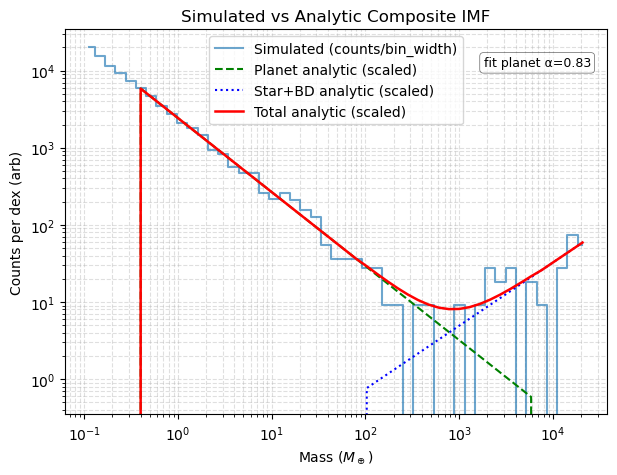

Scale factor applied to analytic model: 1.516e+02
Analytic planet slope α4 = 0.96, star+BD slope α3 = -0.82
BD amplitude (module solved) A_BD = 2.221e-03 dex^-1 star^-1


In [11]:
if 'sumi_files' in globals() and sumi_files:
    # Rebuild masses_earth and histogram if not in scope (idempotent)
    if 'sumi_df' not in globals():
        import pandas as pd
        sumi_df = pd.read_csv(sumi_files[0], sep=',', header=0)
        sumi_df.columns.values[0] = sumi_df.columns[0].replace('# ', '')
        sumi_df.columns = sumi_df.columns.str.strip()
    mE = 3.00348959632e-6
    masses_earth = sumi_df['mass (M_Sun)'] / mE

    # Histogram in log10(M)
    n_bins = 50
    logM = np.log10(masses_earth)
    bins = np.linspace(logM.min(), logM.max(), n_bins)
    hist, bin_edges = np.histogram(logM, bins=bins)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    bin_width = bin_edges[1] - bin_edges[0]
    dN_dlogM = hist / bin_width  # counts per dex

    # Fit slope for the planet segment only (exclude high-mass sparse tail)
    # Use a mass ceiling of 3000 M_earth for the planetary regime consistency check
    planet_reg_hi = np.log10(3000.)
    mask = (bin_centers <= planet_reg_hi) & (dN_dlogM > 0)
    x = bin_centers[mask]
    y = np.log10(dN_dlogM[mask])
    if len(x) > 2:
        slope, intercept = np.polyfit(x, y, 1)
        fitted_alpha = -slope  # expected ~0.96
        y_fit = slope * x + intercept
        residuals = y - y_fit
        rms = np.sqrt(np.mean(residuals**2))
        print(f"Fitted slope (log10 dN/dlogM vs log10 M): {slope:.3f}")
        print(f"=> Implied alpha_log (target 0.96): {fitted_alpha:.3f}")
        print(f"RMS scatter (dex): {rms:.3f}")
    else:
        slope = intercept = fitted_alpha = rms = np.nan
        print("Not enough populated bins for slope fit.")

    # --- Composite analytic IMF (planet + star/BD) ---
    # Use published parameters from sumi2023_composite_imf module
    from sumi2023_composite_imf import (
        composite_imf,
        PLANET_ALPHA4,
        BD_AMPLITUDE,
        STARBD_ALPHA3,
    )

    M_centers_earth = 10 ** bin_centers
    planet_model, starbd_model, total_model = composite_imf(M_centers_earth)

    # Scale analytic total model to match sampled histogram (least squares over populated bins)
    populated = dN_dlogM > 0
    # Avoid zero division if model has zeros (it shouldn't inside validity)
    model_vals = total_model[populated]
    data_vals = dN_dlogM[populated]
    k_scale = np.sum(data_vals * model_vals) / np.sum(model_vals ** 2)
    planet_scaled = k_scale * planet_model
    starbd_scaled = k_scale * starbd_model
    total_scaled = k_scale * total_model

    # Plot
    plt.figure(figsize=(7, 5))
    plt.step(10 ** bin_centers, dN_dlogM, where='mid', label='Simulated (counts/bin_width)', alpha=0.65)
    plt.plot(M_centers_earth, planet_scaled, 'g--', label='Planet analytic (scaled)')
    plt.plot(M_centers_earth, starbd_scaled, 'b:', label='Star+BD analytic (scaled)')
    plt.plot(M_centers_earth, total_scaled, 'r-', lw=1.8, label='Total analytic (scaled)')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'Mass ($M_\oplus$)')
    plt.ylabel(r'Counts per dex (arb)')
    plt.title('Simulated vs Analytic Composite IMF')
    if not np.isnan(fitted_alpha):
        plt.text(0.97, 0.93, f"fit planet α={fitted_alpha:.2f}", transform=plt.gca().transAxes,
                 ha='right', va='top', fontsize=9,
                 bbox=dict(boxstyle='round', fc='white', alpha=0.6, lw=0.5))
    plt.legend()
    plt.grid(True, which='both', ls='--', alpha=0.4)
    plt.show()

    # Diagnostics / sanity checks
    print(f"Scale factor applied to analytic model: {k_scale:.3e}")
    print(f"Analytic planet slope α4 = {PLANET_ALPHA4}, star+BD slope α3 = {STARBD_ALPHA3}")
    print(f"BD amplitude (module solved) A_BD = {BD_AMPLITUDE:.3e} dex^-1 star^-1")
else:
    print('No Sumi 2023 planet files found for analytic comparison.')

SICK!

## Fixing the Sumi Mass function

Fitted slope (log10 dN/dlogM vs log10 M): -0.918
=> Implied alpha_log (target 0.96): 0.918
RMS scatter (dex): 0.123


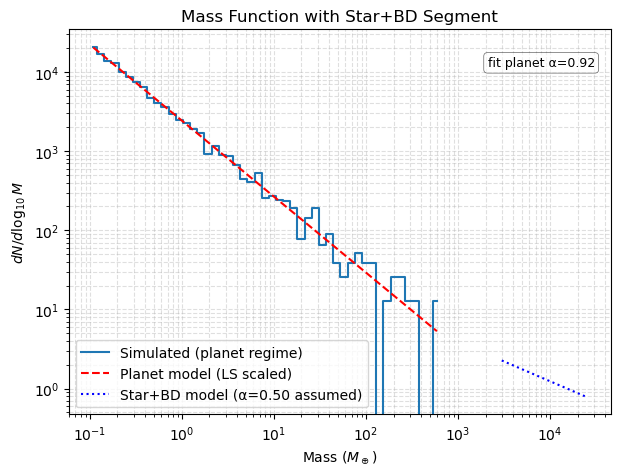

Planet LS normalization k = 3.307e+02; Planet value at break = 4.871e+00
(Adjust alpha_starbd to match paper's star+BD slope if different.)


In [9]:
if 'sumi_files' in globals() and sumi_files:
    # Rebuild masses_earth and histogram if not in scope (idempotent)
    if 'sumi_df' not in globals():
        import pandas as pd
        sumi_df = pd.read_csv(sumi_files[0], sep=',', header=0)
        sumi_df.columns.values[0] = sumi_df.columns[0].replace('# ', '')
        sumi_df.columns = sumi_df.columns.str.strip()
    mE = 3.00348959632e-6
    masses_earth = sumi_df['mass (M_Sun)'] / mE

    # Histogram in log10(M)
    n_bins = 50
    logM = np.log10(masses_earth)
    bins = np.linspace(logM.min(), logM.max(), n_bins)
    hist, bin_edges = np.histogram(logM, bins=bins)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    bin_width = bin_edges[1] - bin_edges[0]
    dN_dlogM = hist / bin_width  # counts per dex

    # Fit slope: log10(dN/dlogM) vs log10(M)
    mask = dN_dlogM > 0
    x = bin_centers[mask]
    y = np.log10(dN_dlogM[mask])
    if len(x) > 2:
        slope, intercept = np.polyfit(x, y, 1)
        fitted_alpha = -slope  # expected ~0.96
        y_fit = slope * x + intercept
        residuals = y - y_fit
        rms = np.sqrt(np.mean(residuals**2))
        print(f"Fitted slope (log10 dN/dlogM vs log10 M): {slope:.3f}")
        print(f"=> Implied alpha_log (target 0.96): {fitted_alpha:.3f}")
        print(f"RMS scatter (dex): {rms:.3f}")
    else:
        print("Not enough populated bins for slope fit.")

    # Planet model (same as before)
    alpha_planet = 0.96
    Mnorm = 8.0  # Earth masses pivot
    M_centers = 10 ** bin_centers
    planet_shape_full = (M_centers / Mnorm) ** (-alpha_planet)
    # Only keep bins with data for LS
    planet_shape = planet_shape_full[mask]
    data_vals = dN_dlogM[mask]
    k_planet = np.sum(data_vals * planet_shape) / np.sum(planet_shape**2)  # LS normalization
    planet_model_vals = k_planet * planet_shape_full  # full array for plotting

    # --- Star+BD segment (assumed slope) ---
    # Assumption: star+BD (blue dotted in paper) has a shallower slope in dN/dlog M.
    # Placeholder slope; adjust to match paper if actual value differs.
    alpha_starbd = 0.5  # dN/dlog10 M ∝ M^{-alpha_starbd}; ASSUMPTION
    M_break_upper_planet = masses_earth.max()  # ~25000 Earth masses (upper planet range)
    # Continuity: set normalization so star+BD model equals planet model at break.
    # Compute planet model value at break mass (interpolate)
    planet_value_break = k_planet * (M_break_upper_planet / Mnorm) ** (-alpha_planet)
    # Generate star+BD mass grid within requested range 3000–25000 M_earth
    starbd_min = 3000.0
    starbd_max = 25000.0
    M_starbd = np.logspace(np.log10(starbd_min), np.log10(starbd_max), 200)
    starbd_shape = (M_starbd / M_break_upper_planet) ** (-alpha_starbd)  # pivot at break => value 1 at break
    starbd_model = planet_value_break * starbd_shape

    # Plot
    plt.figure(figsize=(7,5))
    plt.step(10**bin_centers, dN_dlogM, where='mid', label='Simulated (planet regime)')
    plt.plot(M_centers, planet_model_vals, 'r--', label='Planet model (LS scaled)')
    plt.plot(M_starbd, starbd_model, 'b:', label=f'Star+BD model (α={alpha_starbd:.2f} assumed)')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'Mass ($M_\oplus$)')
    plt.ylabel(r'$dN/d\log_{10} M$')
    plt.title('Mass Function with Star+BD Segment')
    plt.legend()
    plt.text(0.97, 0.93, f"fit planet α={fitted_alpha:.2f}", transform=plt.gca().transAxes,
             ha='right', va='top', fontsize=9, bbox=dict(boxstyle='round', fc='white', alpha=0.6, lw=0.5))
    plt.grid(True, which='both', ls='--', alpha=0.4)
    plt.show()

    print(f"Planet LS normalization k = {k_planet:.3e}; Planet value at break = {planet_value_break:.3e}")
    print("(Adjust alpha_starbd to match paper's star+BD slope if different.)")
else:
    print('No Sumi 2023 planet files found for sanity check.')

Files aggregated: 1231; Total planets: 12310000
Planet-segment fitted alpha (expected 0.96): 0.958


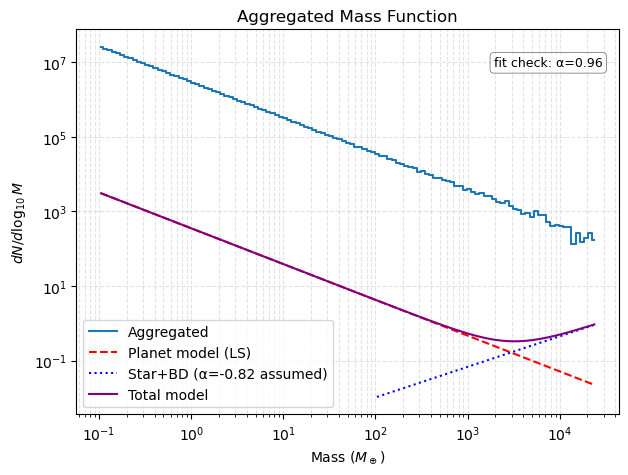

In [ ]:
# Aggregate dN/dlog10 M over all Sumi2023 files without holding everything in RAM
import os, math

if 'sumi_files' in globals() and sumi_files:
    mE = 3.00348959632e-6
    # Define fixed log10 mass bin edges spanning full model range
    logM_min = math.log10(0.1)
    logM_max = math.log10(25000.0)
    n_bins = 120  # finer bins for better high-mass sampling
    bin_edges = np.linspace(logM_min, logM_max, n_bins)
    hist_total = np.zeros(n_bins-1, dtype=float)
    file_count = 0
    total_planets = 0

    for path in sumi_files:
        try:
            # Load only mass column using numpy (fast, low memory)
            masses_solar = np.loadtxt(path, delimiter=',', usecols=0, comments='#')
        except Exception as e:
            print(f"Skip {path}: {e}")
            continue
        masses_earth = masses_solar / mE
        logM = np.log10(masses_earth)
        # Accumulate histogram
        h, _ = np.histogram(logM, bins=bin_edges)
        hist_total += h
        total_planets += masses_earth.size
        file_count += 1

    if file_count == 0:
        print('No readable Sumi2023 files for aggregation.')
    else:
        bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        bin_width = bin_edges[1] - bin_edges[0]  # uniform
        dN_dlogM = hist_total / bin_width

        # Fit slope over a selectable mass range (planet regime); exclude very highest sparse tail
        fit_lo = math.log10(0.3)   # exclude below 0.3 M_earth if desired
        fit_hi = math.log10(3000.) # stop at 3000 for planet segment
        fit_mask = (bin_centers >= fit_lo) & (bin_centers <= fit_hi) & (dN_dlogM > 0)
        x = bin_centers[fit_mask]
        y = np.log10(dN_dlogM[fit_mask])
        if len(x) > 2:
            slope, intercept = np.polyfit(x, y, 1)
            fitted_alpha = -slope
            print(f"Files aggregated: {file_count}; Total planets: {total_planets}")
            print(f"Planet-segment fitted alpha (expected 0.96): {fitted_alpha:.3f}")
        else:
            fitted_alpha = np.nan
            print('Insufficient populated bins for slope fit.')

        # Planet model (normalized by least squares in fit range)
        alpha_planet = 0.96
        Mnorm = 8.0  # Earth masses pivot
        Z = 2.18 # per ( dex x star )
        Z /= bin_width # convert to per bin
        M_centers = 10 ** bin_centers
        planet_shape = Z * (M_centers / Mnorm) ** (-alpha_planet)
        ls_mask = fit_mask
        #k_planet = np.sum(dN_dlogM[ls_mask] * planet_shape[ls_mask]) / np.sum(planet_shape[ls_mask]**2)
        planet_model = planet_shape

        # Star+BD segment as before (assumed slope) within specified range
        alpha_starbd = -0.82  # ASSUMPTION; adjust when true slope known
        starbd_min = 3E-4
        starbd_max = 0.08
        mE = 3.00348959632e-6
        M_centers_solar = M_centers * mE
        M_starbd = M_centers_solar[(M_centers_solar >= starbd_min) & (M_centers_solar <= starbd_max)]
        #planet_value_break = k_planet * (starbd_max / Mnorm) ** (-alpha_planet)
        starbd_model = (M_starbd / starbd_max) ** (-alpha_starbd)
        
        all_model = planet_model.copy()
        all_model[(M_centers_solar >= starbd_min) & (M_centers_solar <= starbd_max)] += starbd_model

        # Plot aggregated
        plt.figure(figsize=(7,5))
        plt.step(M_centers, dN_dlogM, where='mid', label='Aggregated')
        plt.plot(M_centers, planet_model, 'r--', label='Planet model (LS)')
        plt.plot(
            M_centers[(M_centers_solar >= starbd_min) & (M_centers_solar <= starbd_max)], 
            starbd_model, 'b:', label=f'Star+BD (α={alpha_starbd:.2f} assumed)'
        )
        plt.plot(M_centers, all_model, '-', color='purple', label='Total model')
        plt.xscale('log'); plt.yscale('log')
        plt.xlabel(r'Mass ($M_\oplus$)'); plt.ylabel(r'$dN/d\log_{10} M$')
        plt.title('Aggregated Mass Function')
        if not np.isnan(fitted_alpha):
            plt.text(0.97, 0.93, f"fit check: α={fitted_alpha:.2f}", transform=plt.gca().transAxes,
                     ha='right', va='top', fontsize=9,
                     bbox=dict(boxstyle='round', fc='white', alpha=0.6, lw=0.5))
        plt.legend(); plt.grid(True, which='both', ls='--', alpha=0.35)
        plt.show()
else:
    print('No Sumi 2023 planet files found.')

## Analytic Reconstruction (No Sim Data)
We ignore any simulated catalog and directly rebuild a simplified version of the Sumi (2023) composite IMF (red curve) as the **sum** of:

1. Free–floating / wide‐orbit planetary population (FFP)   
   dN/dlog10 M = Z_planet * (M / Mnorm_planet)^(-alpha4)   
   Parameters (CR2, Eq. (MF_PL2)):  
   - alpha4 = 0.96  
   - Z_planet = 2.18 dex^-1 star^-1 (pivot Mnorm_planet = 8 M_⊕)  
   - Valid mass range: 10^-6 < M/M_☉ < 0.02  → 0.33 < M/M_⊕ < 6660.
   Integrated number per star over this stated range should be f ≈ 21.

2. Star + Brown Dwarf (BD) low–mass tail (one power segment only, for the upturn)  
   dN/dlog10 M = Z_starbd * (M / Mnorm_starbd)^(-alpha3) with alpha3 negative.  
   Parameters (text translation to MS+BD normalization):  
   - alpha3 = -0.82 (user focus; paper also quotes ~ -0.58 in another fit — change below to test)  
   - Z_starbd = 0.53 dex^-1 star^-1 (pivot Mnorm_starbd = 38 M_⊕)  
   - Adopt validity: 3×10^-4 < M/M_☉ < 0.8  (≈ 100 < M/M_⊕ < 2.6×10^5).  

Because alpha3 < 0, (M/Mnorm)^(-alpha3) = (M/Mnorm)^(|alpha3|) rises with mass. Summing a **declining** planet power law and a **rising** star+BD segment produces the characteristic upturn / minimum near their crossover mass (≈ few×10^2–10^3 M_⊕).

Notes / Simplifications:
- We ignore higher-mass IMF breaks (α1, α2) and any bound-planet (grey dashed) component; goal is only the red curvature origin.
- Both normalizations are already per star; they can be added directly in overlapping mass regions.
- We verify numerically that integrating the planet component reproduces ≈21 planets per star (consistency check of Z_planet).
- You can toggle alpha3 or Z_starbd to explore sensitivity.

Next cell: implementation + plot (purely analytic).

Integral planets per star (0.33-6660 M_earth): 21.0 (target ~21)
Crossover (planet = star+BD) mass ~ 101 M_earth


/var/folders/yk/2lp5vmnd6s778_4bh__0mvyc0000gp/T/ipykernel_64139/314494889.py:50: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  num_ffp_per_star = np.trapz(planet_sub_dndl, log10M_sub)


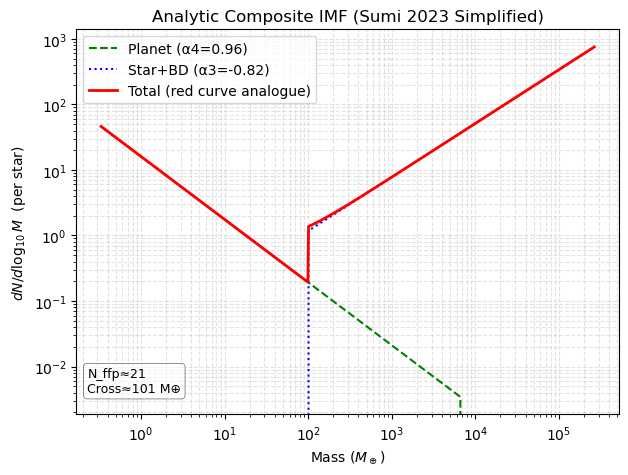


Modify alpha3, Z_starbd to explore curvature. Negative alpha3 makes star+BD rise with mass.


In [ ]:
# Constants
M_EARTH_TO_SOLAR = 3.00348959632e-6

# ---------------------- Parameters (can tweak) ----------------------
# Planet (FFP) component (CR2)
alpha4 = 0.96
Z_planet = 2.18            # dex^-1 star^-1
Mnorm_planet = 8.0         # Earth masses pivot
Mmin_planet_solar = 1e-6   # Msun
Mmax_planet_solar = 0.02   # Msun (~6660 M_earth)

# Star + BD low-mass tail ( adopt alpha3 = -0.82 per user )
alpha3 = -0.82             # dN/dlog M ∝ (M/Mnorm_starbd)^(-alpha3)
Z_starbd = 0.53            # dex^-1 star^-1
Mnorm_starbd = 38.0        # Earth masses pivot
Mmin_starbd_solar = 3e-4   # Msun (~100 M_earth) lower validity for this segment
Mmax_starbd_solar = 0.8    # Msun upper (not really needed for plot)

# Mass grid in Earth masses covering combined domain
Mmin_plot_solar = min(Mmin_planet_solar, Mmin_starbd_solar)
Mmax_plot_solar = max(Mmax_planet_solar, Mmax_starbd_solar)
M_grid_solar = np.logspace(np.log10(Mmin_plot_solar), np.log10(Mmax_plot_solar), 800)
M_grid_earth = M_grid_solar / M_EARTH_TO_SOLAR

# Planet validity mask and model
planet_mask = (M_grid_solar >= Mmin_planet_solar) & (M_grid_solar <= Mmax_planet_solar)
planet_model = np.zeros_like(M_grid_earth)
planet_model[planet_mask] = Z_planet * (M_grid_earth[planet_mask] / Mnorm_planet) ** (-alpha4)

# Star+BD segment mask and model (single rising power law over its validity)
starbd_mask = (M_grid_solar >= Mmin_starbd_solar) & (M_grid_solar <= Mmax_starbd_solar)
starbd_model = np.zeros_like(M_grid_earth)
starbd_model[starbd_mask] = Z_starbd * (M_grid_earth[starbd_mask] / Mnorm_starbd) ** (-alpha3)

# Composite
total_model = planet_model + starbd_model

# ---------------------- Consistency Checks ----------------------
# Integrate planet number per star over stated canonical planet range: 0.33 - 6660 M_earth (given in text)
canon_lo = 0.33
canon_hi = 6660.
# Use fine sub-grid restricted to planet range
M_planet_sub = np.logspace(np.log10(canon_lo), np.log10(canon_hi), 4000)
# dN/dlog10 M formula
planet_sub_dndl = Z_planet * (M_planet_sub / Mnorm_planet) ** (-alpha4)
# Integral over log10 M: sum( dN/dlog10 M * dlog10 M )
log10M_sub = np.log10(M_planet_sub)
num_ffp_per_star = np.trapz(planet_sub_dndl, log10M_sub)

# Location of minimum (crossover) for information only
# Rough: where planet_model == starbd_model
with np.errstate(divide='ignore', invalid='ignore'):
    ratio = np.where(starbd_model>0, planet_model / starbd_model, np.nan)
min_idx = np.nanargmin(np.abs(ratio-1)) if np.any(np.isfinite(ratio)) else None
crossover_mass = M_grid_earth[min_idx] if min_idx is not None else np.nan

print(f"Integral planets per star (0.33-6660 M_earth): {num_ffp_per_star:.1f} (target ~21)")
print(f"Crossover (planet = star+BD) mass ~ {crossover_mass:.0f} M_earth")

# ---------------------- Plot ----------------------
plt.figure(figsize=(7,5))
plt.plot(M_grid_earth, planet_model, 'g--', label='Planet (α4=0.96)')
plt.plot(M_grid_earth, starbd_model, 'b:', label=f'Star+BD (α3={alpha3})')
plt.plot(M_grid_earth, total_model, 'r-', lw=2, label='Total (red curve analogue)')
plt.xscale('log'); plt.yscale('log')
plt.xlabel(r'Mass ($M_\oplus$)')
plt.ylabel(r'$dN/d\log_{10} M$  (per star)')
plt.title('Analytic Composite IMF (Sumi 2023 Simplified)')
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.35)
plt.text(0.02,0.05, f'N_ffp≈{num_ffp_per_star:.0f}\nCross≈{crossover_mass:.0f} M⊕', transform=plt.gca().transAxes,
         ha='left', va='bottom', fontsize=9,
         bbox=dict(boxstyle='round', fc='white', alpha=0.6, lw=0.5))
plt.show()

# Guidance prints for adjusting parameters
print('\nModify alpha3, Z_starbd to explore curvature. Negative alpha3 makes star+BD rise with mass.')


### Clarifying Normalizations (Why BD number looked wrong)
`Z_planet = 2.18 dex^-1 star^-1` is the published normalization for the **planetary (FFP) population** (pivot 8 M_⊕) relative to *stars (MS+BD+WD)*. Integrating this power law over 0.33–6660 M_⊕ produces f ≈ 21 planets per star; we did not tune it by hand.

`0.53 dex^-1 star^-1` (with pivot 38 M_⊕) is **NOT** the BD (or MS+BD) normalization; it is an *alternative expression of the planetary normalization* when referenced to the MS+BD denominator only (different pivot). I incorrectly used it as if it were the brown dwarf mass function amplitude; that inflates/deflates BD counts.

To model the BD (and very low–mass star) tail you need the *stellar IMF segment* with slope α3 and its own amplitude, which is determined by continuity with higher-mass IMF segments (α2, α1) or by imposing a target number of BD objects per star in a chosen BD mass interval.

Below we introduce a free parameter `N_BD_target` over (M1, M2) in Msun (e.g. BD range 0.013–0.08 Msun). From that we solve for the correct amplitude `A_BD` for:

    dN_BD/dlog10 M = A_BD * (M / Mnorm_starbd)^(-alpha3)

(where α3 is negative). Set `N_BD_target` to whatever empirical / literature BD-per-star figure you prefer; the code then recomputes the composite curve **without** misusing 0.53.

Solved BD amplitude A_BD = 0.002 dex^-1 star^-1 (target N_BD=0.2 in [0.012,0.08] Msun)
Check BD count [0.012,0.08] Msun = 0.200 (target 0.2)
Planet count 0.33–6660 M_earth = 21.0 (~21)


/var/folders/yk/2lp5vmnd6s778_4bh__0mvyc0000gp/T/ipykernel_64139/1690133954.py:52: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  num_ffp_per_star = np.trapz(planet_sub_dndl, np.log10(M_planet_sub_earth))
/var/folders/yk/2lp5vmnd6s778_4bh__0mvyc0000gp/T/ipykernel_64139/1690133954.py:57: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  N_BD_check = np.trapz(BD_dndl, np.log10(M_BD_sub))


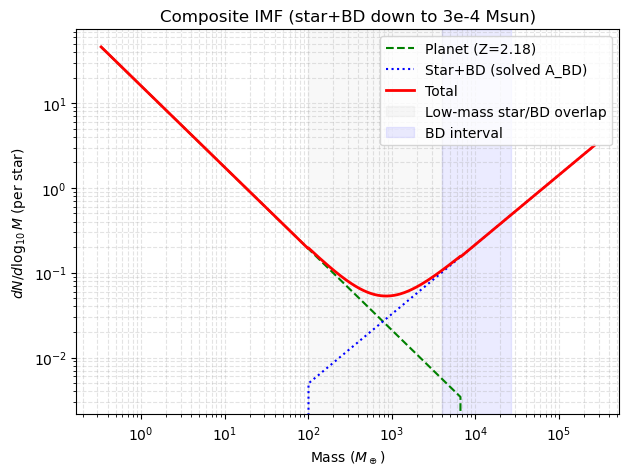

Change N_BD_target or BD_lo/BD_hi if you want a different BD frequency; star+BD validity now starts at 3e-4 Msun.


In [ ]:
# Planet parameters (kept identical)
alpha4 = 0.96
Z_planet = 2.18        # dex^-1 star^-1 (planet normalization)
Mnorm_planet = 8.0     # Earth masses
Mmin_planet_solar = 1e-6
Mmax_planet_solar = 0.02

# Star+BD IMF segment
alpha3 = -0.82
Mnorm_starbd_solar = 38.0 * M_EARTH_TO_SOLAR  # pivot
starbd_valid_lo = 3e-4   # Msun (paper lower bound for MS+BD integration)
starbd_valid_hi = 0.8    # Msun

# BD interval for setting amplitude (can be adjusted); keep classical BD range if desired
BD_lo = 0.012   # Msun (13 M_Jup)
BD_hi = 0.08    # Msun
N_BD_target = 0.2  # target BD count per star in [BD_lo, BD_hi]

# Solve amplitude A_BD for dN/dlog10 M = A_BD * (M/Mnorm_starbd_solar)^(-alpha3)
x1, x2 = np.log10(BD_lo), np.log10(BD_hi)
ln10 = np.log(10.0)
M0 = Mnorm_starbd_solar
numer = N_BD_target * (-alpha3) * ln10
denom = (M0**alpha3) * (10**(-alpha3 * x2) - 10**(-alpha3 * x1))
A_BD = numer / denom
print(f"Solved BD amplitude A_BD = {A_BD:.3f} dex^-1 star^-1 (target N_BD={N_BD_target} in [{BD_lo},{BD_hi}] Msun)")

# Mass grid
M_grid_solar = np.logspace(np.log10(min(Mmin_planet_solar, starbd_valid_lo)) , np.log10(starbd_valid_hi), 900)
M_grid_earth = M_grid_solar / M_EARTH_TO_SOLAR

# Planet component
planet_mask = (M_grid_solar >= Mmin_planet_solar) & (M_grid_solar <= Mmax_planet_solar)
planet_model = np.zeros_like(M_grid_solar)
planet_model[planet_mask] = Z_planet * (M_grid_earth[planet_mask] / Mnorm_planet) ** (-alpha4)

# Star+BD component over its validity range
starbd_mask = (M_grid_solar >= starbd_valid_lo) & (M_grid_solar <= starbd_valid_hi)
starbd_model = np.zeros_like(M_grid_solar)
starbd_model[starbd_mask] = A_BD * (M_grid_solar[starbd_mask] / M0) ** (-alpha3)

# Composite
total_model = planet_model + starbd_model

# Planet integral check (0.33–6660 M_earth)
M_planet_sub = np.logspace(np.log10(0.33 * M_EARTH_TO_SOLAR), np.log10(6660 * M_EARTH_TO_SOLAR), 4000)
M_planet_sub_earth = M_planet_sub / M_EARTH_TO_SOLAR
planet_sub_dndl = Z_planet * (M_planet_sub_earth / Mnorm_planet) ** (-alpha4)
num_ffp_per_star = np.trapz(planet_sub_dndl, np.log10(M_planet_sub_earth))

# BD interval verification
M_BD_sub = np.logspace(np.log10(BD_lo), np.log10(BD_hi), 3000)
BD_dndl = A_BD * (M_BD_sub / M0) ** (-alpha3)
N_BD_check = np.trapz(BD_dndl, np.log10(M_BD_sub))
print(f"Check BD count [{BD_lo},{BD_hi}] Msun = {N_BD_check:.3f} (target {N_BD_target})")
print(f"Planet count 0.33–6660 M_earth = {num_ffp_per_star:.1f} (~21)")

# Plot
plt.figure(figsize=(7,5))
plt.plot(M_grid_earth, planet_model, 'g--', label='Planet (Z=2.18)')
plt.plot(M_grid_earth, starbd_model, 'b:', label='Star+BD (solved A_BD)')
plt.plot(M_grid_earth, total_model, 'r-', lw=2, label='Total')
plt.axvspan(starbd_valid_lo / M_EARTH_TO_SOLAR, BD_lo / M_EARTH_TO_SOLAR, color='gray', alpha=0.05, label='Low-mass star/BD overlap')
plt.axvspan(BD_lo / M_EARTH_TO_SOLAR, BD_hi / M_EARTH_TO_SOLAR, color='b', alpha=0.08, label='BD interval')
plt.xscale('log'); plt.yscale('log')
plt.xlabel(r'Mass ($M_\oplus$)')
plt.ylabel(r'$dN/d\log_{10} M$ (per star)')
plt.title('Composite IMF (star+BD down to 3e-4 Msun)')
plt.legend(loc='best')
plt.grid(True, which='both', ls='--', alpha=0.35)
plt.show()

print("Change N_BD_target or BD_lo/BD_hi if you want a different BD frequency; star+BD validity now starts at 3e-4 Msun.")

In [49]:
# Reusable functional form: composite IMF (planet + star/BD) without any fitting

M_EARTH_TO_SOLAR = 3.00348959632e-6
LN10 = np.log(10.0)

# Default published / chosen parameters
PLANET_ALPHA4 = 0.96
PLANET_Z = 2.18            # dex^-1 star^-1
PLANET_MNORM_EARTH = 8.0
PLANET_MMIN_SOLAR = 1e-6
PLANET_MMAX_SOLAR = 0.02   # 6660 M_earth

STARBD_ALPHA3 = -0.82
STARBD_MNORM_SOLAR = 38.0 * M_EARTH_TO_SOLAR
STARBD_VALID_LO_SOLAR = 3e-4
STARBD_VALID_HI_SOLAR = 0.8

# Brown dwarf interval used to set amplitude
BD_LO_SOLAR = 0.012   # Msun (~13 M_Jup)
BD_HI_SOLAR = 0.08    # Msun
BD_TARGET_PER_STAR = 0.2

def solve_bd_amplitude(alpha3=STARBD_ALPHA3,
                        Mnorm_solar=STARBD_MNORM_SOLAR,
                        bd_lo=BD_LO_SOLAR, bd_hi=BD_HI_SOLAR,
                        N_target=BD_TARGET_PER_STAR):
    """Return amplitude A_BD (dex^-1 star^-1) so that integral over bd_lo..bd_hi equals N_target.
    dN/dlog10 M = A_BD * (M / Mnorm_solar)^(-alpha3).
    """
    x1, x2 = np.log10(bd_lo), np.log10(bd_hi)
    numer = N_target * (-alpha3) * LN10
    denom = (Mnorm_solar**alpha3) * (10**(-alpha3 * x2) - 10**(-alpha3 * x1))
    return numer / denom

# Precompute once (so downstream users can just use BD_AMPLITUDE without recomputing)
BD_AMPLITUDE = solve_bd_amplitude()
# For reference this should be ~2.23e-3 dex^-1 star^-1

def planetary_component_dndl_log10M(M_earth,
                                    Z=PLANET_Z,
                                    alpha4=PLANET_ALPHA4,
                                    Mnorm_earth=PLANET_MNORM_EARTH,
                                    mmin_solar=PLANET_MMIN_SOLAR,
                                    mmax_solar=PLANET_MMAX_SOLAR):
    """Planet free-floating IMF piece. Returns array dN/dlog10 M (per star).
    Outside validity range returns 0.
    M_earth: ndarray of masses in Earth masses.
    """
    M_solar = M_earth * M_EARTH_TO_SOLAR
    mask = (M_solar >= mmin_solar) & (M_solar <= mmax_solar)
    out = np.zeros_like(M_earth, dtype=float)
    out[mask] = Z * (M_earth[mask] / Mnorm_earth) ** (-alpha4)
    return out

def starbd_component_dndl_log10M(M_earth,
                                 A_bd=BD_AMPLITUDE,
                                 alpha3=STARBD_ALPHA3,
                                 Mnorm_solar=STARBD_MNORM_SOLAR,
                                 valid_lo=STARBD_VALID_LO_SOLAR,
                                 valid_hi=STARBD_VALID_HI_SOLAR):
    """Star + BD low-mass IMF segment (single power law) returning dN/dlog10 M.
    Valid for valid_lo <= M_solar <= valid_hi; outside returns 0.
    """
    M_solar = M_earth * M_EARTH_TO_SOLAR
    mask = (M_solar >= valid_lo) & (M_solar <= valid_hi)
    out = np.zeros_like(M_earth, dtype=float)
    out[mask] = A_bd * (M_solar[mask] / Mnorm_solar) ** (-alpha3)
    return out

def composite_imf(M_earth,
                  planet_kwargs=None,
                  starbd_kwargs=None):
    """Return (planet, starbd, total) dN/dlog10 M arrays for input masses (Earth masses)."""
    planet_kwargs = planet_kwargs or {}
    starbd_kwargs = starbd_kwargs or {}
    p = planetary_component_dndl_log10M(M_earth, **planet_kwargs)
    s = starbd_component_dndl_log10M(M_earth, **starbd_kwargs)
    return p, s, p + s

# --------------- Example usage ---------------
M_plot = np.logspace(np.log10(0.1), np.log10(0.8 / M_EARTH_TO_SOLAR), 800)  # up to 0.8 Msun
p, s, tot = composite_imf(M_plot)
# Sanity integrals
# Free-floating planets over canonical 0.33-6660 M_earth
M_ffp = np.logspace(np.log10(0.33), np.log10(6660.), 4000)
ffp_vals = planetary_component_dndl_log10M(M_ffp)
N_ffp = np.trapz(ffp_vals, np.log10(M_ffp))
# Brown dwarfs over chosen BD interval
M_bd = np.logspace(np.log10(BD_LO_SOLAR / M_EARTH_TO_SOLAR), np.log10(BD_HI_SOLAR / M_EARTH_TO_SOLAR), 3000)
bd_vals = starbd_component_dndl_log10M(M_bd)
N_bd = np.trapz(bd_vals, np.log10(M_bd))
print(f"BD_AMPLITUDE (constant): {BD_AMPLITUDE:.6g} dex^-1 star^-1  -> BD count ≈ {N_bd:.3f} (target {BD_TARGET_PER_STAR})")
print(f"Planet count 0.33-6660 M_earth ≈ {N_ffp:.1f} (expected ~21)")


BD_AMPLITUDE (constant): 0.00222103 dex^-1 star^-1  -> BD count ≈ 0.200 (target 0.2)
Planet count 0.33-6660 M_earth ≈ 20.9 (expected ~21)


/var/folders/yk/2lp5vmnd6s778_4bh__0mvyc0000gp/T/ipykernel_64139/696626281.py:87: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  N_ffp = np.trapz(ffp_vals, np.log10(M_ffp))
/var/folders/yk/2lp5vmnd6s778_4bh__0mvyc0000gp/T/ipykernel_64139/696626281.py:91: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  N_bd = np.trapz(bd_vals, np.log10(M_bd))


Planet canonical count (~21): 20.9
BD count (target 0.2): 0.200


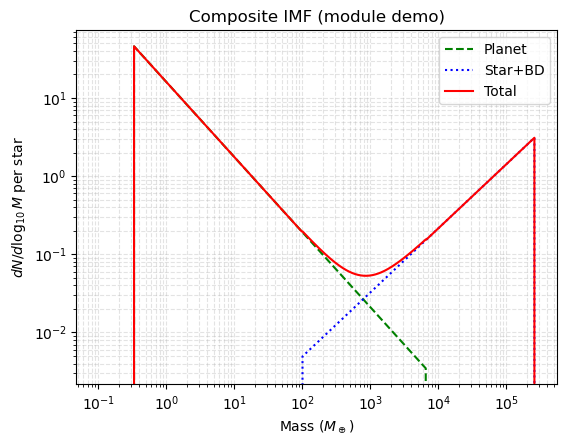

In [51]:
# Demo: use external module implementation
from sumi2023_composite_imf import composite_imf, M_EARTH_TO_SOLAR, planet_canonical_count, bd_count_in_interval

M = np.logspace(np.log10(0.1), np.log10(0.8 / M_EARTH_TO_SOLAR), 600)
planet, starbd, total = composite_imf(M)

print(f"Planet canonical count (~21): {planet_canonical_count():.1f}")
print(f"BD count (target 0.2): {bd_count_in_interval():.3f}")

plt.figure(figsize=(6.2,4.6))
plt.plot(M, planet, 'g--', label='Planet')
plt.plot(M, starbd, 'b:', label='Star+BD')
plt.plot(M, total, 'r-', label='Total')
plt.xscale('log'); plt.yscale('log')
plt.xlabel(r'Mass ($M_\oplus$)'); plt.ylabel(r'$dN/d\log_{10} M$ per star')
plt.legend(); plt.grid(True, which='both', ls='--', alpha=0.35)
plt.title('Composite IMF (module demo)')
plt.show()

Slopes (planet, star+BD): (-0.96, 0.82)  Intercepts (c1,c2): (1.205, -3.949)
Value ranges planet[3.47e-03,1.33e+03]  starBD[4.94e-03,3.16e+00]


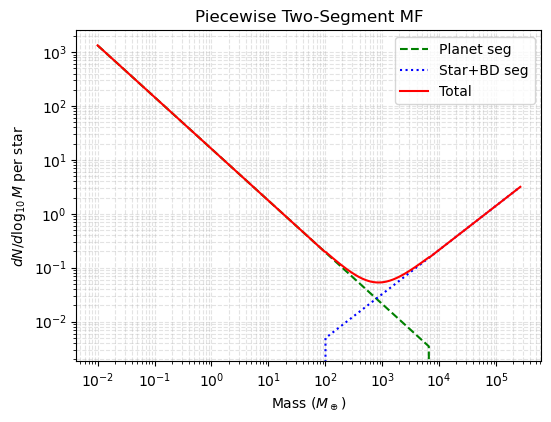

In [60]:
# Minimal piecewise mass function per your pseudocode
import numpy as np

# Physical parameters (can be tweaked)
_ALPHA_PLANET = 0.96          # slope exponent alpha4
_Z_PLANET = 2.18              # dex^-1 star^-1 at pivot 8 M_earth
_PIVOT_PLANET = 8.0           # M_earth
_PLANET_LO = 0.33             # M_earth validity
_PLANET_HI = 6660.0           # M_earth validity

_ALPHA3 = -0.82               # star+BD exponent (negative => rising)
_A_BD = 2.22103e-3            # dex^-1 star^-1 amplitude solved earlier
_PIVOT_BD = 38.0              # M_earth pivot for star+BD segment
# Star+BD validity in solar masses (convert to Earth masses)
_M_EARTH_TO_SOLAR = 3.00348959632e-6
_STARBD_LO_SOLAR = 3e-4
_STARBD_HI_SOLAR = 0.8
_STARBD_LO = _STARBD_LO_SOLAR / _M_EARTH_TO_SOLAR
_STARBD_HI = _STARBD_HI_SOLAR / _M_EARTH_TO_SOLAR

# Pre-compute straight-line (log-log) parameters.
# log10(dN/dlogM) = m * log10(M) + c
# Planet: slope m1 = -alpha4; intercept c1 = log10(Z) + alpha4*log10(M_pivot)
_m1 = -_ALPHA_PLANET
_c1 = np.log10(_Z_PLANET) + _ALPHA_PLANET * np.log10(_PIVOT_PLANET)
# Star+BD: slope m2 = -alpha3; intercept c2 = log10(A_BD) + alpha3*log10(M_pivot_bd)
_m2 = -_ALPHA3
_c2 = np.log10(_A_BD) + _ALPHA3 * np.log10(_PIVOT_BD)


def MF(logM, m1=_m1, c1=_c1, m2=_m2, c2=_c2,
       planet_lo=_PLANET_LO, planet_hi=_PLANET_HI,
       starbd_lo=_STARBD_LO, starbd_hi=_STARBD_HI,
       return_components=False):
    """Piecewise (sum) mass function dN/dlog10 M per star.

    Parameters
    ----------
    logM : array-like (log10 M_earth)
    m1,c1 : slope & intercept for planet segment (log space)
    m2,c2 : slope & intercept for star+BD segment (log space)
    planet_lo, planet_hi : planet validity (M_earth)
    starbd_lo, starbd_hi : star+BD validity (M_earth)
    return_components : if True returns (total, planet_only, starbd_only)
    """
    logM = np.asarray(logM, dtype=float)
    M = 10**logM
    out = np.zeros_like(logM)
    if np.max(M) > starbd_hi:
        raise ValueError(f'Mass {np.max(M):.2e} M_earth exceeds star+BD upper limit {starbd_hi:.2e}')

    # Masks
    mask_planet = (M <= planet_hi)
    mask_starbd = (M >= starbd_lo)

    # Compute log dN/dlogM only where needed
    planet_vals = np.zeros_like(logM)
    if np.any(mask_planet):
        log_planet = m1 * logM[mask_planet] + c1
        planet_vals[mask_planet] = 10**log_planet

    starbd_vals = np.zeros_like(logM)
    if np.any(mask_starbd):
        log_star = m2 * logM[mask_starbd] + c2
        starbd_vals[mask_starbd] = 10**log_star

    out += planet_vals
    out += starbd_vals
    if return_components:
        return out, planet_vals, starbd_vals
    return out

# Demo quick check
demo_logM = np.linspace(np.log10(0.01), np.log10(_STARBD_HI-1), 500)
combined, planet_part, starbd_part = MF(demo_logM, return_components=True)

print(f"Slopes (planet, star+BD): ({_m1:.2f}, {_m2:.2f})  Intercepts (c1,c2): ({_c1:.3f}, {_c2:.3f})")
print(f"Value ranges planet[{planet_part[planet_part>0].min():.2e},{planet_part.max():.2e}]  starBD[{starbd_part[starbd_part>0].min():.2e},{starbd_part.max():.2e}]")

# (Optional) plot
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4.3))
plt.plot(10**demo_logM, planet_part, 'g--', label='Planet seg')
plt.plot(10**demo_logM, starbd_part, 'b:', label='Star+BD seg')
plt.plot(10**demo_logM, combined, 'r-', label='Total')
plt.xscale('log'); plt.yscale('log')
plt.xlabel(r'Mass ($M_\oplus$)'); plt.ylabel(r'$dN/d\log_{10} M$ per star')
plt.title('Piecewise Two-Segment MF')
plt.legend(); plt.grid(True, which='both', ls='--', alpha=0.35)
plt.show()


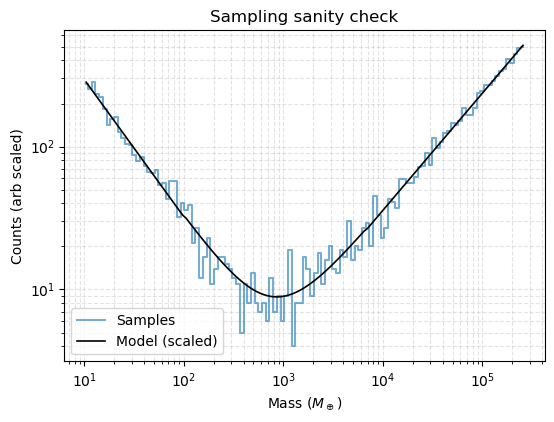

In [ ]:
# Sampling utilities for the piecewise MF()

_DEF_RNG = np.random.default_rng()

def _segment_integral(m, c, a, b):
    """Integral of 10^{m x + c} dx over [a,b] (x = log10 M)."""
    if abs(m) < 1e-12:
        # Flat in log-space: 10^c ∫ dx = 10^c (b-a)
        return 10**c * (b - a)
    k = m * np.log(10.0)
    # K = 10^c; integral K * (e^{k b} - e^{k a}) / k
    K = 10**c
    return K * (np.exp(k * b) - np.exp(k * a)) / k

def _sample_segment(m, c, a, b, size, rng):
    """Sample log10 M values from density ∝ 10^{m x + c} on [a,b]."""
    u = rng.random(size)
    if abs(m) < 1e-12:
        # Uniform in x
        return a + (b - a) * u
    k = m * np.log(10.0)
    ea = np.exp(k * a)
    eb = np.exp(k * b)
    return (1.0 / k) * np.log(ea + u * (eb - ea))

def sample_masses(N, *,
                  planet_lo=_PLANET_LO, planet_hi=_PLANET_HI,
                  starbd_lo=_STARBD_LO, starbd_hi=_STARBD_HI,
                  m1=_m1, c1=_c1, m2=_m2, c2=_c2,
                  rng=_DEF_RNG, return_component=False):
    """Draw N masses (M_earth) from the total piecewise MF (planet + star/BD).

    We treat the two segments as independent additive components over their
    validity ranges and sample a mixture with weights given by their integrals
    in log-space (counts per dex). Overlapping ranges are naturally handled by
    independent mixture selection.

    Parameters
    ----------
    N : int, number of draws
    planet_* : planet segment bounds (Earth masses)
    starbd_* : star+BD segment bounds (Earth masses)
    m1,c1 : planet log-space slope & intercept (log10 dN/dlog10M)
    m2,c2 : star+BD log-space slope & intercept
    rng : numpy Generator
    return_component : if True also return array of labels (0=planet,1=starbd)

    Returns
    -------
    masses : ndarray of sampled masses in Earth masses
    (labels) : optional component labels
    """
    a1, b1 = np.log10(planet_lo), np.log10(planet_hi)
    a2, b2 = np.log10(starbd_lo), np.log10(starbd_hi)
    I1 = _segment_integral(m1, c1, a1, b1)
    I2 = _segment_integral(m2, c2, a2, b2)
    p1 = I1 / (I1 + I2)
    # Bernoulli for component choice
    comp = rng.random(N) >= p1  # True -> segment 2
    n2 = comp.sum()
    n1 = N - n2
    logM_out = np.empty(N, dtype=float)
    if n1:
        logM_out[~comp] = _sample_segment(m1, c1, a1, b1, n1, rng)
    if n2:
        logM_out[comp] = _sample_segment(m2, c2, a2, b2, n2, rng)
    masses = 10**logM_out
    if return_component:
        return masses, comp.astype(int)
    return masses

# Quick sanity test: sample and compare binned shape
if __name__ == '__main__':
    draws, labels = sample_masses(100000, return_component=True)
    log_bins = np.linspace(np.log10(min(_PLANET_LO, _STARBD_LO)), np.log10(_STARBD_HI), 120)
    hist, edges = np.histogram(np.log10(draws), bins=log_bins)
    centers = 0.5 * (edges[1:] + edges[:-1])
    model = MF(centers)
    # Scale model to sample counts for rough visual check
    model_scaled = model / model.sum() * hist.sum()
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6.2,4.3))
    plt.step(10**centers, hist, where='mid', label='Samples', alpha=0.6)
    plt.plot(10**centers, model_scaled, 'k-', lw=1.2, label='Model (scaled)')
    plt.xscale('log'); plt.yscale('log')
    plt.xlabel(r'Mass ($M_\oplus$)'); plt.ylabel('Counts (arb scaled)')
    plt.title('Sampling sanity check')
    plt.legend(); plt.grid(True, which='both', ls='--', alpha=0.35)
    plt.show()
